# COVID-19 Detection in Chest X-Ray Images
The goal of this project is to build a model that identifies COVID-19, pneumonia in chest X-Ray images. The dataset is organized into 3 folders (COVID-19 cases, Normal , Pneumonia) and contains subfolders for each image category. There are 606 X-Ray images (JPEG). Data from [Mendeley](https://data.mendeley.com/datasets/fvk7h5dg2p/1). 

In [16]:
# Download and unzip
dataroot = "dataroot/"
!wsl mkdir dataroot 
!wsl wget -P dataroot https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/fvk7h5dg2p-1.zip

--2025-04-03 11:40:50--  https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/fvk7h5dg2p-1.zip
Resolving prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)... 52.92.16.210, 52.218.120.34, 3.5.64.104, ...
Connecting to prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)|52.92.16.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 198985388 (190M) [application/octet-stream]
Saving to: ‘dataroot/fvk7h5dg2p-1.zip’

     0K .......... .......... .......... .......... ..........  0%  345K 9m23s
    50K .......... .......... .......... .......... ..........  0%  316K 9m48s
   100K .......... .......... .......... .......... ..........  0% 3.29M 6m51s
   150K .......... .......... .......... .......... ..........  0%  401K 7m10s
   200K .......... .......... .......... .......... ..........  0% 3.90M 5m53s
   250K 

The file naming structure from the zip file has irregularities that are causing issues with the extraction. The following was done to sanitize and then extract.

In [ ]:
import zipfile
import os

zip_path = dataroot + "fvk7h5dg2p-1.zip"

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    for file in zip_ref.namelist():
        sanitized_name = file.strip().replace("\\", "/")  # Ensure consistent path format
        
        # Sanitize folder name for "Normal "
        if sanitized_name.startswith("Normal "):
            sanitized_name = sanitized_name.replace("Normal ", "Normal", 1)

        # Create the full target path within the 'Normal' folder
        target_path = os.path.join(dataroot, sanitized_name)

        # Skip directories (avoid trying to open them as files)
        if file.endswith("/"):
            os.makedirs(target_path, exist_ok=True)
            continue

        # Ensure the parent directory exists before extracting
        os.makedirs(os.path.dirname(target_path), exist_ok=True)

        # Extract file safely
        with zip_ref.open(file) as source, open(target_path, "wb") as target:
            target.write(source.read())

print("Extraction completed successfully.")


Extraction completed successfully.


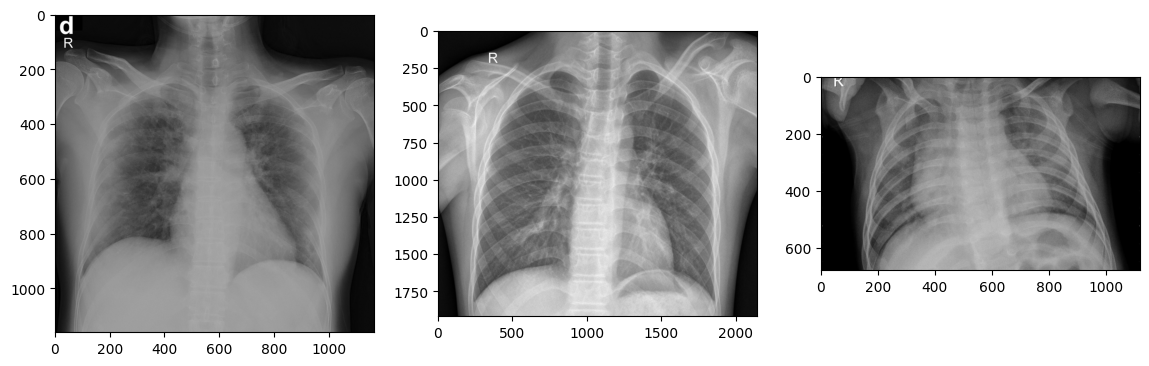

In [19]:
# Load and preview images
import matplotlib.pyplot as plt
import numpy as np
import cv2

img_covid     = cv2.imread(dataroot+'COVID-19 cases/1-s2.0-S0929664620300449-gr2_lrg-d.jpg',0)
img_normal    = cv2.imread(dataroot+'Normal/IM-0011-0001-0001.jpeg',0)
img_pneumonia = cv2.imread(dataroot+'Pneumonia/person1650_virus_2854.jpeg',0)

plt.figure(figsize=(14,14))
plt.subplot(1,3,1)
plt.imshow(img_covid,cmap='gray')
plt.subplot(1,3,2)
plt.imshow(img_normal,cmap='gray')
plt.subplot(1,3,3)
plt.imshow(img_pneumonia,cmap='gray')